# Choosing warm-up length

A suitable length for the warm-up period can be determined using the **time series inspection approach**. This involves looking at performance measures over time to identify when the system is exhibiting **steady state behaviour** (even though the system will never truly reach a "steady state").

If we simply plot the mean result at regular intervals, this would vary too much. Therefore, we plot the **cumulative mean** of the performance measure, and look for the point at which this **smoothes out and stabilises**. This indicates the point for the warm-up period to end.

This should be assessed when running the model using the base case parameters. If these change, you should reassess the appropriate warm-up period.

We should:

* Run the model with **multiple replications** (e.g. at least five).
* Use a **long run length** (i.e. 5-10 times actual planned run length).

The run time is provided at the end of the notebook.

Credit:

* Code for choice of warm-up period was adapted from Tom Monks (2024) [HPDM097 - Making a difference with health data](https://github.com/health-data-science-OR/stochastic_systems) (MIT Licence).

## Set-up

Load required packages.

In [1]:
# pylint: disable=missing-module-docstring
# To ensure any updates to `simulation/` are fetched without needing to restart
# the notebook environment, reload `simulation/` before execution of each cell
%load_ext autoreload
%autoreload 1
%aimport simulation

In [2]:
# pylint: disable=wrong-import-position
import os
import time

import plotly.io as pio
import plotly.graph_objects as go
import plotly.subplots as sp

from simulation.model import Param, Runner

Display plotly express figures as non-interactive figures. This means they will be visible when browsing the notebooks on GitHub. To switch these back to interactive figures, simply remove this line.

In [3]:
pio.renderers.default = 'svg'

Start timer.

In [4]:
notebook_start_time = time.time()

Define path to outputs folder

In [5]:
# pylint: disable=duplicate-code
OUTPUT_DIR = '../outputs/'

Define labels for variables in the dataset.

In [6]:
LABELS = {
    'arrivals': 'Patient arrivals (n)',
    'mean_q_time_nurse': 'Mean wait time for nurse (minutes)',
    'mean_n_consult_time': 'Mean consultation time with nurse (minutes)',
    'mean_time_with_nurse': 'Mean consultation time with nurse (minutes)',
    'mean_nurse_utilisation': 'Mean nurse utilisation',
    'adj_mean_nurse_utilisation': 'Mean nurse utilisation (*100 - %)',
    'adj_mean_q_time_nurse': 'Mean wait time for nurse (*100) (minutes)',
    'mean_nurse_utilisation_tw': 'Time-weighted mean nurse utilisation',
    'mean_nurse_q_length': 'Time-weighted mean queue length for nurse (n)',
    'patient_inter': 'Patient inter-arrival time',
    'number_of_nurses': 'Number of nurses',
    'utilisation': 'Utilisation',
    'running_mean_wait_time': 'Running mean nurse wait time (minutes)'
}

## Determining appropriate warm-up length

In [7]:
def time_series_inspection(
    file,
    data_collection_period=Param().data_collection_period*10,
    warm_up=None,
    path=OUTPUT_DIR,
    labels=None
):
    """
    Time series inspection method for determining length of warm-up.

    Arguments:
        file (str):
            Filename to save figure to.
        data_collection_period (float):
            Length of time to run the simulation for - default is ten times
            the length of the default data collection period.
        warm_up (float, optional):
            Location on X axis to plot vertical red line indicating the chosen
            warm-up period. Defaults to None, which will not plot a line.
        path (str):
            Path to save file to (exc. filename)
        labels (dict):
            Contains mappings from variable names to full labels. If none
            provided, will default to using variable names.

    Acknowledgements:
        - Adapted from Monks 2024.
    """
    # Use default parameters, but with no warm-up, five replications, and the
    # specified data collection period
    param = Param(warm_up_period=0,
                  data_collection_period=data_collection_period,
                  number_of_runs=5)

    # Run model
    choose_warmup = Runner(param)
    choose_warmup.run_reps()

    # Filter to nurse results
    nurse = choose_warmup.interval_audit_df[
        choose_warmup.interval_audit_df['resource_name'] == 'nurse']

    # Define columns to analyse
    plot = ['utilisation', 'running_mean_wait_time']

    # Create 1x2 subplot
    full_figure = sp.make_subplots(rows=2, cols=1, shared_xaxes=True)

    counter = 1
    for var in plot:
        # Reformat so index is simulation time and columns are each run
        reformat = (
            nurse[['simulation_time', var, 'run']]
            .pivot(index='simulation_time',
                   columns='run',
                   values=var))

        # For utilisation, calculate cumulative mean (not necessary
        # for wait time as that is already a running mean)
        if var == 'utilisation':
            cumulative = reformat.expanding().mean()
        elif var == 'running_mean_wait_time':
            cumulative = reformat.copy()
        else:
            print('Expected var to be utilisation or running_mean_wait_time.')
            break

        # Create plot (using go.Scatter instead of px.express, for sub-plots)

        # Add pale lines plotting the individual replications
        for col in cumulative.columns:
            full_figure.add_trace(
                go.Scatter(
                    x=cumulative.index,
                    y=cumulative[col],
                    mode='lines',
                    line={'color': 'lightblue', 'width': 1},
                    showlegend=False
                ),
                row=counter, col=1
            )

        # Plot the row-wise means (i.e. mean of cumulative means at each time)
        full_figure.add_trace(
            go.Scatter(
                x=cumulative.index,
                y=cumulative.mean(axis=1),
                mode='lines',
                line={'color': 'royalblue'}
            ),
            row=counter, col=1
        )

        # Add y axis label, and trim axes to exclude extreme outliers by
        # calculating the 99th percentile of the data, expanding the range
        # slightly, and updating the y axis to this calculate range
        full_figure.update_yaxes(
            title_text=labels.get(var, var),
            row=counter, col=1,
            range=[0, cumulative.mean(axis=1).quantile(0.99) * 1.2]
        )

        # Add vertical line for warm-up period specified
        if warm_up is not None:
            full_figure.add_vline(
                x=warm_up, line_color='red', line_dash='dash',
                annotation_text='Suggested warm-up length',
                annotation_position='top right',
                annotation_font_color='red')
        counter += 1

    # Add x axis title
    full_figure.update_xaxes(title_text='Run time (minutes)')

    # Set figure dimensions and hide legend
    full_figure.update_layout(
        width=1400,
        height=800,
        showlegend=False,
        template='plotly_white'
    )

    # Show figure
    full_figure.show()

    # Save figure
    full_figure.write_image(os.path.join(path, file))

We've add a line to the point where it appears to reach a steady state - this is a subjective choice but here, for example, we could select **27 days** (1440*27=38880 minutes).

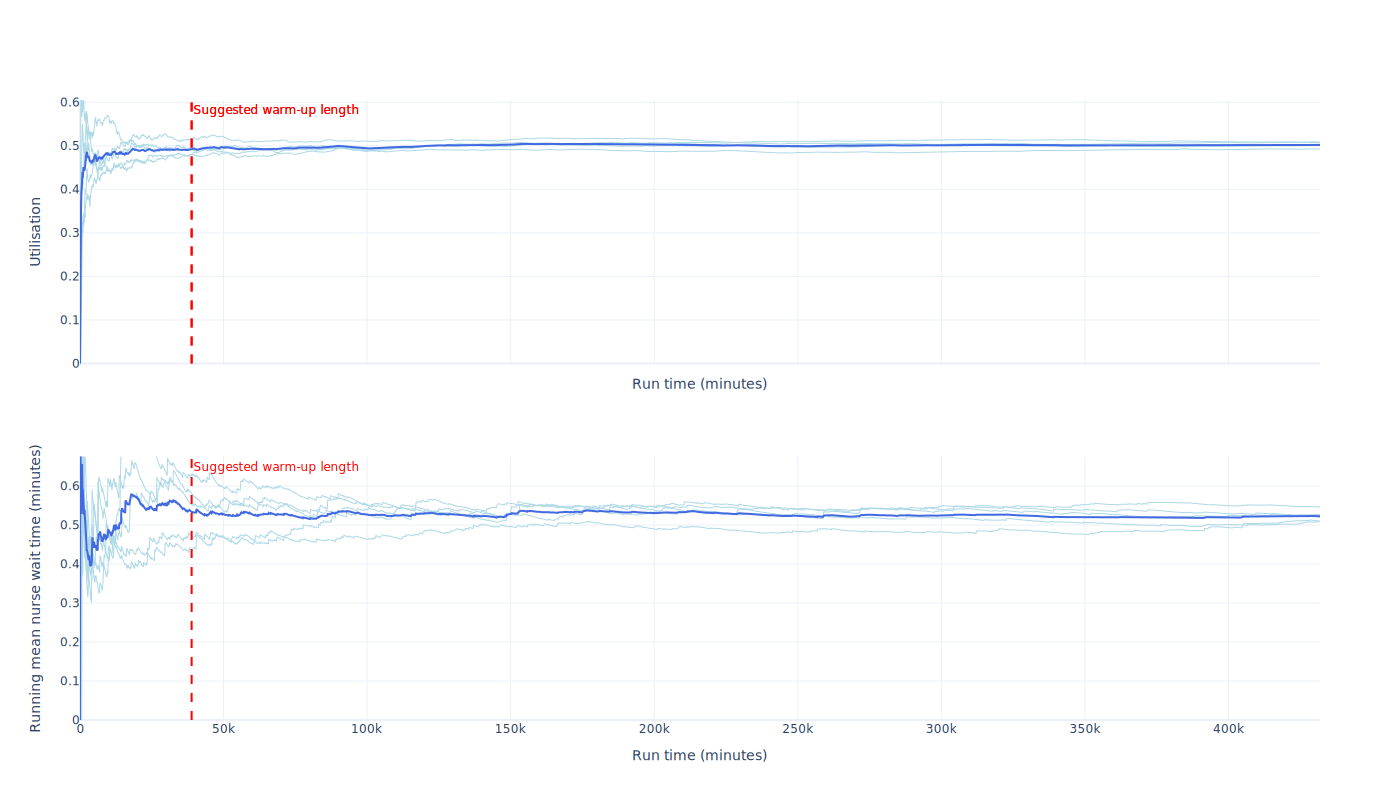

In [8]:
time_series_inspection(
    file='choose_param_time_series.png',
    warm_up=38880,
    labels=LABELS)

## Run time

In [9]:
# Get run time in seconds
notebook_end_time = time.time()
runtime = round(notebook_end_time - notebook_start_time)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime // 60}m {runtime % 60}s')

Notebook run time: 0m 3s
